# Load and Investigate Simulated SN signal shape

In [1]:
import numpy as np
import click
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import multihist as mh
import multimessenger.supernova as sn

import wfsim, strax, straxen, cutax, ntauxfiles
straxen.print_versions(('strax','straxen','cutax','wfsim', 'multimessenger', 'ntauxfiles'),)

*** Detector definition message ***
You are currently using the default XENON10 template detector.



### Get high statistics SN data

In [3]:
st = straxen.contexts.xenonnt_simulation(
    wfsim_registry='RawRecordsFromFaxNT',
    cmt_run_id_sim='026000',
    cmt_run_id_proc='026000',
    cmt_version='global_v7',
    fax_config='/home/melih/software/private_nt_aux_files/sim_files/fax_config_nt_sr0_v0.json',
    overwrite_from_fax_file_sim=True,
    overwrite_from_fax_file_proc=True,
    output_folder='/dali/lgrandi/melih/sn_wfsim/strax_data/')

st.set_config(dict(fax_file='/dali/lgrandi/melih/sn_wfsim/instructions/SN_wfsim_test1.csv', chunk_size=10000))
run_id = 'SN_multi'

print(f'---> Data for "{run_id}" ')
for kind in ['truth', 'raw_records', 'peaks', 'peak_basics']:
    click.echo(f'{kind:15s} is {click.style(" stored ", bold=True, bg="green") if st.is_stored(run_id, kind) else click.style(" not stored ",bold=True,bg="red")}')

---> Data for "SN_wfsimdata_100k" 
truth           is  stored 
raw_records     is  stored 
peaks           is  not stored 
peak_basics     is  stored 


In [4]:
truth = st.get_df(rid,('truth'))
peak_basics = st.get_df(rid, 'peak_basics')
event_info = st.get_df(rid, 'event_info')

Loading truth: |          | 0.00 % [00:00<?]

Loading peak_basics: |          | 0.00 % [00:00<?]

Loading event_info: |          | 0.00 % [00:00<?]

### Get also a single SN event

In [5]:
# sn_utils.see_repos()

In [6]:
st.set_config(dict(nearby_window=5e8))
# st.set_config(dict(fax_file=f'/dali/lgrandi/melih/sn_wfsim/instructions/single_SN.csv'))

rid_single = 'SN_wfsimdata_01'
print(f'---> Data for "{rid_single}" ')
for kind in ['truth', 'raw_records', 'peaks', 'peak_basics']:
    click.echo(f'{kind:15s} is {click.style(" stored ", bold=True, bg="green") if st.is_stored(rid, kind) else click.style(" not stored ",bold=True,bg="red")}')

---> Data for "SN_wfsimdata_01" 
truth           is  stored 
raw_records     is  stored 
peaks           is  not stored 
peak_basics     is  stored 


In [7]:
truth_single = st.get_df(rid_single,('truth'))
peak_basics_single = st.get_df(rid_single, 'peak_basics')
event_info_single = st.get_df(rid_single, 'event_info')

Loading truth: |          | 0.00 % [00:00<?]

Loading peak_basics: |          | 0.00 % [00:00<?]

Loading event_info: |          | 0.00 % [00:00<?]

### Get a background run

In [8]:
st_runs = cutax.xenonnt_v5(cuts_for='commissioning.commissioning_cuts', _minimum_run_number=17917)

In [9]:
# exclude_tags = ('flash', 'ramp_up', 'ramp_down', 'anode_off', 'hot_spot', 'missing_one_pmt', 'messy', 'bad')

# # Not tpc_radon
# runs_bkg = st_runs.select_runs(run_mode='tpc_bkg', include_tags=('_sr0_*'), 
#                                exclude_tags=exclude_tags,  available=('event_basics'), 
#                                ignore_underscore=True)

# bkg_run_id = runs_bkg.sample()['name'].values[0]

In [10]:
bkg_run_id = '019537'
st_runs.set_config(dict(nearby_window=5e8)) # half a second in each direction
peaks_run = st_runs.get_df(bkg_run_id, ('peak_proximity', 'peak_basics'))
peak_prox_rate = peaks_run['n_competing'] / st_runs.config['nearby_window']

Loading plugins: |          | 0.00 % [00:00<?]

In [11]:
sn_utils.display_times(peaks_run['time'])

1621249391 2021-05-17 11:03:11
1621251194 2021-05-17 11:33:14
1803 seconds 
0:00:00.000001 resolution


In [12]:
sn_utils.display_times(peak_basics_single['time'])

0 1970-01-01 00:00:00
1 1970-01-01 00:00:01
1 seconds 
0:00:00.000001 resolution


We need to inject this inside the runs time interval.

In [13]:
signal = sn_utils.inject_in(peak_basics_single, peaks_run)

In [14]:
sn_utils.display_times(signal['time'])

1621249523 2021-05-17 11:05:23
1621249525 2021-05-17 11:05:25
2 seconds 
0:00:00.000001 resolution


Now it is inside our background run!

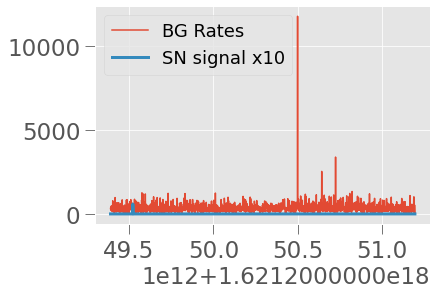

In [15]:
r_run, t_run = sn_utils.compute_rate_within(peaks_run['time'], 1e9, peaks_run['time'].min(), peaks_run['time'].max())
r_sn, t_sn = sn_utils.compute_rate_within(signal['time'], 1e9, peaks_run['time'].min(), peaks_run['time'].max())

plt.plot(t_run[:-1], r_run, label='BG Rates')
plt.plot(t_sn[:-1], r_sn*10, label='SN signal x10', lw=3);
plt.legend(loc='upper left');

### Cleaning
The SN signal only visible when amplified by 100. We should clean the background run to have a more stable signal.

In [16]:
m1 = peaks_run['type'] == 2
m2 = peaks_run['area'] < 600
m3 = peaks_run['range_90p_area'] < 1000
m4 = peaks_run['range_90p_area'] > 300
masks = m1 & m2 & m3 & m4
peaks_bg_filt = peaks_run[masks]

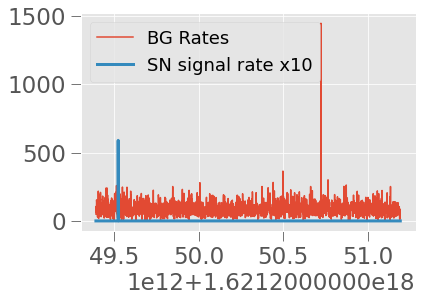

In [17]:
r_run, t_run = sn_utils.compute_rate_within(peaks_bg_filt['time'], 1e9, peaks_run['time'].min(), peaks_run['time'].max())
r_sn, t_sn = sn_utils.compute_rate_within(signal['time'], 1e9, peaks_run['time'].min(), peaks_run['time'].max())

plt.plot(t_run[:-1], r_run, label='BG Rates')
plt.plot(t_sn[:-1], r_sn*10, label='SN signal rate x10', lw=3,);
plt.legend(loc='upper left');

Some initial cuts already give nice results. Tune these cuts using higher statistics data.

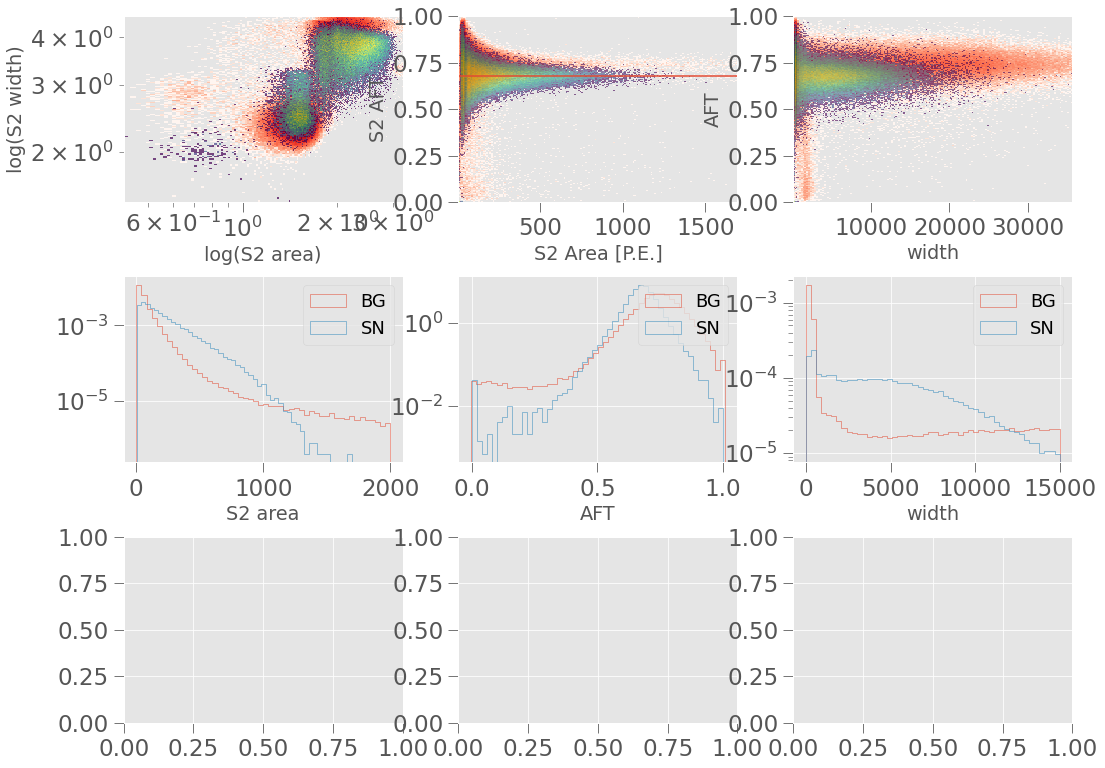

In [20]:
sn_utils_plots.compare_features(peak_basics,peaks_run)

In [61]:
# st_runs.data_info('peak_basics')

In [21]:
def tune_param(signal1, signal2, param='area_fraction_top'):
    """ Return the best cut value
    """
    surv_rat = lambda sig, cut: (len(sig)-len(sig[sig<cut]))/len(sig)
    best = 0
    cut_val = 0
    for cut in np.arange(0,1,0.05):
        surv_ratio_bg = surv_rat(signal1,cut)
        surv_ratio_sn = surv_rat(signal2,cut)
        proxy = surv_ratio_sn - surv_ratio_bg
        if proxy > best:
            best = proxy
            cut_val = cut
    return cut_val

In [25]:
s2_runs = peaks_run[(peaks_run['type']==2)&(peaks_run['area']<2000)]
s2_sn = peak_basics[(peak_basics['type']==2)&(peak_basics['area']<2000)]

In [26]:
signal1 = s2_runs['area_fraction_top']
signal2 = s2_sn['area_fraction_top']

# signal1 = s2_runs['range_90p_area']
# signal2 = s2_sn['range_90p_area']

cut = tune_param(signal1, signal2)
cut

0.45

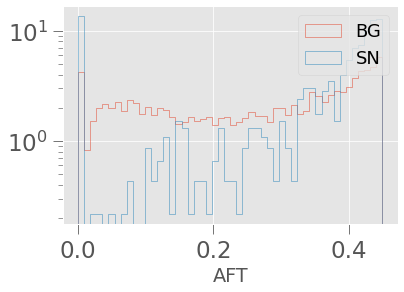

In [27]:
plt.hist(signal1[signal1 < cut], bins=50, histtype='step', density=True, label='BG', range=(0, cut));
plt.hist(signal2[signal2 < cut], bins=50, histtype='step', density=True, label='SN', range=(0, cut));
plt.xlabel('AFT');
plt.legend()
plt.gca().set_yscale('log')

Let's try these cuts.

In [28]:
m1 = peaks_run['type'] == 2
m2 = peaks_run['area'] < 600
m3 = peaks_run['range_50p_area'] < 15_000
m4 = peaks_run['range_50p_area'] > 0
m5 = peaks_run['area_fraction_top'] < 0.5
m6 = (peaks_run['time'] > signal['time'].mean()*.95) & (peaks_run['time'] < signal['time'].mean()*1.05)
masks = m1 & m2 & m3 & m4 & m5 & m6
peaks_bg_filt = peaks_run[masks]
peaks_bg_filt.shape

(7600, 22)

In [29]:
signal_filt = signal[signal['type']==2]

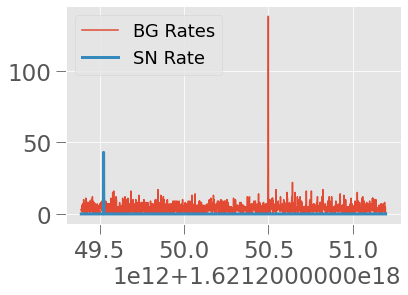

In [30]:
r_run, t_run = sn_utils.compute_rate_within(peaks_bg_filt['time'], 1e9, peaks_run['time'].min(), peaks_run['time'].max())
r_sn, t_sn = sn_utils.compute_rate_within(signal_filt['time'], 1e9, peaks_run['time'].min(), peaks_run['time'].max())

plt.plot(t_run[:-1], r_run, label='BG Rates')
plt.plot(t_sn[:-1], r_sn, label='SN Rate', lw=3);
plt.legend(loc='upper left');

Further cleaning

In [31]:
m = peaks_bg_filt['area'] > 60
peaks_bg_filt = peaks_bg_filt[m]

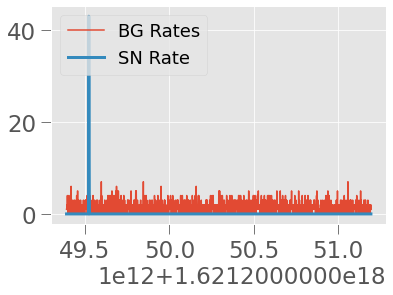

In [32]:
r_run, t_run = sn_utils.compute_rate_within(peaks_bg_filt['time'], 1e9, peaks_run['time'].min(), peaks_run['time'].max())
r_sn, t_sn = sn_utils.compute_rate_within(signal_filt['time'], 1e9, peaks_run['time'].min(), peaks_run['time'].max())

plt.plot(t_run[:-1], r_run, label='BG Rates')
plt.plot(t_sn[:-1], r_sn, label='SN Rate', lw=3);
plt.legend(loc='upper left');

---

Lower level data? Pulses? We should be able to trigger as we read the data. <br>

I think my current rate scan takes discrete steps, but maybe I should move finer? I mean, take 0.5sec steps, compute the rate in the next 5 seconds. That should be more efficient.

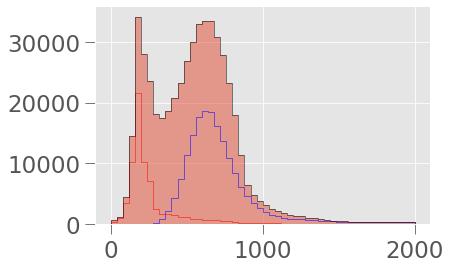

In [78]:
# st_runs.data_info('peak_basics')
plt.hist(peaks_run['range_90p_area'], 50, range=(0,2e3), alpha=0.5);
plt.hist(peaks_run['range_90p_area'][peaks_run['type']==1], 50, range=(0,2e3), histtype='step', color='red');
plt.hist(peaks_run['range_90p_area'][peaks_run['type']==2], 50, range=(0,2e3), histtype='step', color='blue');
plt.hist(peaks_run['range_90p_area'], 50, range=(0,2e3), histtype='step', color='k');

In [33]:
# time_of_peak = t_run[np.where(r_run == r_run.max())[0][0]]
# test_bg_data = peaks_bg_filt.copy()
# test_bg_data = test_bg_data[(test_bg_data['time'] < time_of_peak*1.05)&(test_bg_data['time'] > time_of_peak*.95)]
# plt.hist(test_bg_data['area'], bins=50);

In [34]:
# plt.hist(peaks_bg_filt['n_competing_left'], 50, range=(0,600));

In [37]:
# plt.hist(peaks_bg_filt['t_to_nearest_peak'][peaks_bg_filt['t_to_nearest_peak']>0], 50, range=(0,4000));

In [35]:
# st_runs.data_info('peaks')

In [36]:
# st_runs.data_info('raw_records')

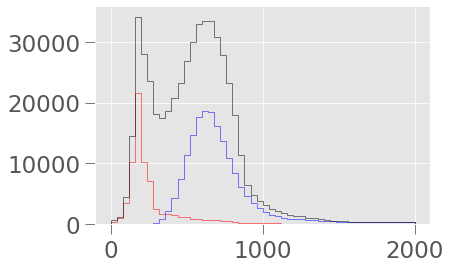

In [45]:
plt.hist(peaks_run['range_90p_area'][peaks_run['type']==1], 50, range=(0,2e3), histtype='step', color='red');
plt.hist(peaks_run['range_90p_area'][peaks_run['type']==2], 50, range=(0,2e3), histtype='step', color='blue');
plt.hist(peaks_run['range_90p_area'], 50, range=(0,2e3), histtype='step', color='k');